In [1]:
import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
#from EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
#from pyriemann.utils.viz import plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from glob import glob

# tools for plotting confusion matrices
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
K.set_image_data_format('channels_last')

In [3]:
data_path = sample.data_path()
print(data_path)

C:\Users\pesylvestre\mne_data\MNE-sample-data


In [4]:
pathdata = "C:/Users/pesylvestre/Documents/Informatique/BRAIL/FY2023 In-House PoC3/In-HousePOC3/in_housepoc3/data/"

In [5]:
gb = glob(pathdata+"sub-032*.csv")

In [6]:
#raw_fname = str(data_path) + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
#event_fname = str(data_path) + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
#tmin, tmax = -0., 1
event_id = dict(age_20_25 =1, age_25_30=2, age_30_35=3, age_35_40=4, age_55_60=5, age_60_65=6, age_65_70=7, age_70_75=8, age_75_80=9)

In [7]:
#raw = io.Raw(raw_fname, preload=True, verbose=False)
#raw.filter(2, None, method='iir')  # replace baselining with high-pass
#events = mne.read_events(event_fname)

In [8]:
#raw.info['bads'] = ['MEG 2443']  # set bad channels
#picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       #exclude='bads')

In [9]:
#epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    #picks=picks, baseline=None, preload=True, verbose=False)
#labels = epochs.events[:, -1]

In [10]:
arr=np.zeros((len(gb),14501,63))

In [11]:
import csv
import numpy as np

In [12]:
arr=np.zeros((len(gb),63,14501))

In [13]:
import pandas as pd
i = 0
for filename in gb:
    if i > 1000:
        continue
    print(filename, end="\r")
    df=pd.read_csv(filename)
    #print(df.values)
    #print(df.shape)
    if df.shape[0] == 14501:
        arr[i]=df.T.values
    i=i+1

print(arr.shape, arr)

(2438, 63, 14501) re/Documents/Informatique/BRAIL/FY2023 In-House PoC3/In-HousePOC3/in_housepoc3/data\sub-032395_EC3_eeg.csv[[[ 0.00000000e+00  4.00000000e-03  8.00000000e-03 ...  5.79920000e+01
    5.79960000e+01  5.80000000e+01]
  [ 4.43099604e+00  9.29993362e-01 -2.51943588e+00 ... -1.03355189e+00
    1.23344036e+00  3.75175956e+00]
  [-6.09678655e+00  1.53566527e+00  3.32119603e+00 ... -1.45541010e+00
    2.53001694e+00  6.74658741e+00]
  ...
  [-8.25740802e+00 -1.02092397e+01 -1.19413316e+01 ... -2.19583311e+01
   -1.64163607e+01 -7.37770108e+00]
  [-6.29691431e+00 -3.40233242e+00 -2.44495481e+00 ... -2.62064339e+01
   -2.23936851e+01 -1.41744868e+01]
  [-1.84043513e+00  1.02355918e+00  9.58074830e-01 ... -3.16844065e+01
   -2.91202513e+01 -2.03665873e+01]]

 [[ 0.00000000e+00  4.00000000e-03  8.00000000e-03 ...  5.79920000e+01
    5.79960000e+01  5.80000000e+01]
  [-5.82788061e+00 -8.90241076e+00 -1.74663192e+01 ...  1.25033608e+01
    1.18108939e+00 -6.85292335e+00]
  [-8.114727

In [14]:
with open(pathdata+"clab.csv",'r') as dest_f:
    data_iter = csv.reader(dest_f,
                           delimiter = ',',
                           quotechar = '"')
    data = [data for data in data_iter]
data_array = np.asarray(data[0][:-1]).astype(np.int)
print(data_array)
print(data_array.shape)

[7 7 7 ... 1 1 1]
(2438,)


C:\Users\PESYLV~1\AppData\Local\Temp/ipykernel_29472/4242893162.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_array = np.asarray(data[0][:-1]).astype(np.int)


In [15]:
X = arr[:1000]
y = data_array[:1000]
print(type(X))
print(y)
print(X.shape, y.shape)

<class 'numpy.ndarray'>
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 7 7 7 7 7 7 7
 7 7 7 7 7 7 2 2 2 2 2 2 2 2 2 2 2 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 2 2 2 2 2 2 2 2 2 2 2 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 1 1 1 1 1 1 1 1 1 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 7 7 7 7 7 7 7 7 7 2 2 2 2 2 2 2 2 2
 2 2 2 8 8 8 8 8 8 8 8 8 8 8 8 8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 8 8 8 8 8 8 8
 8 8 8 8 3 3 3 3 3 3 3 3 3 3 3 3 3 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 9 9 9 9 9 9 9 9 9 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8
 8 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 

In [16]:
kernels, chans, samples = 1, 63, 14501
p50 = int(len(y)/2)
p75 = int(len(y)*0.75)

In [17]:
X_train      = X[0:p50,]
Y_train      = y[0:p50]
X_validate   = X[p50:p75,]
Y_validate   = y[p50:p75]
X_test       = X[p75:,]
Y_test       = y[p75:]

In [18]:
Y_train      = np_utils.to_categorical(Y_train-1)
Y_validate   = np_utils.to_categorical(Y_validate-1)
Y_test       = np_utils.to_categorical(Y_test-1)

In [19]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(Y_train.shape[0], 'train samples')
print(Y_test.shape[0], 'test samples')

X_train shape: (500, 63, 14501)
500 train samples
250 test samples
500 train samples
250 test samples


In [20]:
n_components = 2

In [21]:
clf = make_pipeline(XdawnCovariances(n_components, estimator='oas'),
                    TangentSpace(metric='riemann'),
                    LogisticRegression())

In [22]:
X_train = X_train.reshape(X_train.shape[0], chans, samples)
X_test = X_test.reshape(X_test.shape[0], chans, samples)

In [23]:
clf.fit(X_train, Y_train.argmax(axis = -1))
preds_rg = clf.predict(X_test)

In [29]:
acc2 = np.mean(preds_rg == Y_test.argmax(axis = -1))
print("Classification accuracy: %f " % (acc2*100), end="")
print("%")

Classification accuracy: 8.800000 %


<Figure size 432x288 with 0 Axes>

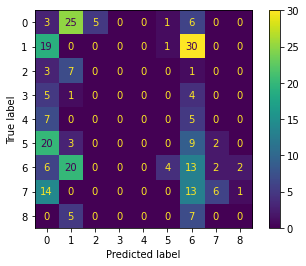

In [30]:
names = ['audio left', 'audio right', 'vis left', 'vis right']
plt.figure(0)
cm = confusion_matrix(Y_test.argmax(axis = -1), preds_rg)
ConfusionMatrixDisplay(cm).plot()
plt.show()